# Hohmann transfer

This tutorial provides a practical example on how to solve a Hohmann transfer problem using Python.

## What is a Hohmann transfer?

A Hohmann transfer is a fuel-efficient orbital maneuver used in spaceflight to transfer a spacecraft from one circular orbit to another circular orbit at a different altitude or around a different celestial body. It was developed by German engineer Walter Hohmann in 1925 and is often referred to as the Hohmann transfer orbit or Hohmann ellipse. This maneuver is commonly used for missions within the solar system, including transfers between planets or moons.

The orbit transfer is typically modeled under the two-body assumption. This means that it assumes a simplified scenario where only two significant gravitational bodies are considered: the spacecraft and the central body (for example, a planet or a moon).

It is composed of two impulses. The first impulse takes place at the periapsis of the transfer orbit. The last impulse takes place at the apoapsis of the transfer orbit.

## Problem statement

A satellite presents an circular and equatorial orbit with a periapsis radius of $6700$ kilometers. Propagate this parking orbit for $2$ hours. Next, apply a Hohmann transfer to raise the apoapsis radius up to $42238$ km. Finally, propagate the new orbit for $1$ day.

Compute the required $\Delta v$ for each impulse of the maneuver.

## Launch a new STK instance

Start by launching a new STK instance. In this example, ``STKEngine`` is used in ``no_graphics`` mode. This means that the graphic user interface (GUI) of the product is not launched:

In [1]:
from ansys.stk.core.stkengine import STKEngine


stk = STKEngine.start_application(no_graphics=False)
print(f"Using {stk.version}")

Using STK Engine v12.10.0


## Create a new scenario

Start by creating a new scenario in STK by running:

In [2]:
root = stk.new_object_root()
root.new_scenario("HohmannTransfer")

Once created, it is possible to show a 3D graphics window by running:

RFBOutputContext()

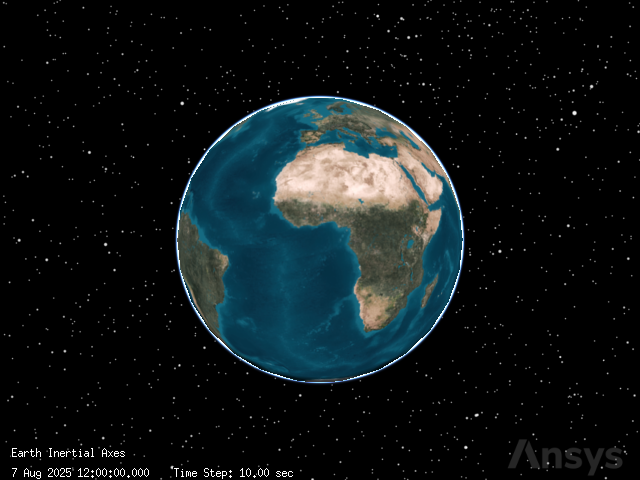

In [3]:
from ansys.stk.core.stkengine.experimental.jupyterwidgets import GlobeWidget


plotter = GlobeWidget(root, 640, 480)
plotter.show()

## Adding a satellite to the scenario

Now that a new scenario is available, add a new satellite:

In [4]:
from ansys.stk.core.stkobjects import STKObjectType


satellite = root.current_scenario.children.new(STKObjectType.SATELLITE, "Satellite")

Then, declare the type of orbit propagator used for the satellite:

In [5]:
from ansys.stk.core.stkobjects import PropagatorType


satellite.set_propagator_type(PropagatorType.ASTROGATOR)

Initialize the propagator by making sure that no previous sequence is present. Add any additional configurations for the propagator. For this example, its is requested to draw the maneuver in 3D.

In [6]:
satellite.propagator.main_sequence.remove_all()
satellite.propagator.options.draw_trajectory_in_3d = True

## Set up the initial state of the satellite

Start by adding a new segment to the main sequence for modeling the initial state of the satellite:

In [7]:
from ansys.stk.core.stkobjects.astrogator import SegmentType


initial_state = satellite.propagator.main_sequence.insert(
    SegmentType.INITIAL_STATE, "Initial State", "-"
)

A total of six orbital parameters are required to specify the initial state of the satellite. Considering the data provided in this example, Keplerian elements can be used. Thus, it is possible to assign the following parameters:

In [8]:
from ansys.stk.core.stkobjects.astrogator import ElementSetType


initial_state.set_element_type(ElementSetType.KEPLERIAN)

initial_state.element.periapsis_radius_size = 6700.00
initial_state.element.eccentricity = 0.00
initial_state.element.inclination = 0.00
initial_state.element.raan = 0.00
initial_state.element.arg_of_periapsis = 0.00
initial_state.element.true_anomaly = 0.00

## Propagate the parking orbit of the satellite

The parking orbit is the temporary orbit that the satellite follows before starting any maneuver. Modelling a parking orbit requires inserting a new `PROPAGATE` segment type in the main sequence. To be consistent with the assumptions of the Hohmann transfer, the segment should be propagated using an `Earth point mass` propagator. The total duration of the propagation is set for $7200$ seconds, that is $2$ hours.

In [9]:
parking_orbit_propagate = satellite.propagator.main_sequence.insert(
    SegmentType.PROPAGATE, "Parking Orbit Propagate", "-"
)
parking_orbit_propagate.propagator_name = "Earth point mass"
parking_orbit_propagate.stopping_conditions["Duration"].properties.trip = 7200

Additional configurations, like the color used to visualize the orbit of the satellite, can also be declared by running:

In [10]:
from ansys.stk.core.utilities.colors import Colors


parking_orbit_propagate.properties.color = Colors.Blue

## Set up the Hohmann transfer

The Hohmann transfer can be modelled as a sequence composed by three segments:


- **First impulse**: it is applied at the periapsis to raise the radius of apoapsis up to a desired value.
- **Propagation**: the satellite is propagated along its new transfer orbit until it reaches the apogee.
- **Last impulse**: it is a applied in the perigee of the transfer orbit to achieve a circular orbit.

A differential corrector is required for solving the first and last impulses to achieve the desired radius of apoapsis and a circular orbit. Therefore, these segments need to be modeled using a `TARGET_SEQUENCE` segment type. Regarding the propagation segment, this can be modeled using a `PROPAGATION` segment type. All these segments can be collected under a `SEQUENCE` segment type.

All maneuvers are modeled as `IMPULSIVE` maneuver type. The attitude control used is of the type `THRUST_VECTOR`.

In [11]:
from ansys.stk.core.stkobjects.astrogator import AttitudeControl, ManeuverType


hohmann_transfer = satellite.propagator.main_sequence.insert(
    SegmentType.SEQUENCE, "Hohmann Transfer", "-"
)

hohmann_start = hohmann_transfer.segments.insert(
    SegmentType.TARGET_SEQUENCE, "Hohmann Start", "-"
)
first_impulse = hohmann_start.segments.insert(
    SegmentType.MANEUVER, "First Impulse", "-"
)
first_impulse.set_maneuver_type(ManeuverType.IMPULSIVE)
first_impulse.maneuver.set_attitude_control_type(AttitudeControl.THRUST_VECTOR)

hohmann_propagate = hohmann_transfer.segments.insert(
    SegmentType.PROPAGATE, "Hohmann Propagate", "-"
)
hohmann_propagate.propagator_name = "Earth Point Mass"

hohmann_end = hohmann_transfer.segments.insert(
    SegmentType.TARGET_SEQUENCE, "Hohmann End", "-"
)
last_impulse = hohmann_end.segments.insert(SegmentType.MANEUVER, "Last Impulse", "-")
last_impulse.set_maneuver_type(ManeuverType.IMPULSIVE)
last_impulse.maneuver.set_attitude_control_type(AttitudeControl.THRUST_VECTOR)

Finally, it is possible to visualize the segments layout of the Hohmann transfer sequence by running:

In [12]:
print(hohmann_transfer.name)
for control_sequence in hohmann_transfer.segments:
    try:
        print(f"\t{control_sequence.name}")
        for segment in control_sequence.segments:
            print(f"\t\t{segment.name}")
    except:
        continue

Hohmann Transfer
	Hohmann Start
		First Impulse
		-
	Hohmann Propagate
	Hohmann End
		Last Impulse
		-
	-


### First impulse

Enable the component of the velocity impulse along the X axis as a control parameter. Add the radius of apoapsis as a result to be achieved.

In [13]:
from ansys.stk.core.stkobjects.astrogator import ControlManeuver


first_impulse.enable_control_parameter(ControlManeuver.IMPULSIVE_CARTESIAN_X)
first_impulse.results.add("Keplerian Elems/Radius of Apoapsis")

Now, configure the solver for this first impulse. A differential corrector can be used to solve for the values of the control parameters to achieved the desired results:

In [14]:
from ansys.stk.core.stkobjects.astrogator import ProfileMode


hohmann_start_solver = hohmann_start.profiles["Differential Corrector"]
hohmann_start_solver.mode = ProfileMode.ITERATE
hohmann_start_solver.max_iterations = 50

delta_v1_x = hohmann_start_solver.control_parameters.get_control_by_paths(
    "First Impulse", "ImpulsiveMnvr.Cartesian.X"
)
delta_v1_x.enable = True
delta_v1_x.max_step = 0.30

desired_radius_of_apoapsis = hohmann_start_solver.results.get_result_by_paths(
    "First Impulse", "Radius Of Apoapsis"
)
desired_radius_of_apoapsis.enable = True
desired_radius_of_apoapsis.desired_value = 42238.00
desired_radius_of_apoapsis.tolerance = 0.10

### Propagation

After the first impulse, a propagation segment takes place in a Hohmann transfer. The stopping condition is imposed to take place at the apoapsis of the orbit:

In [15]:
hohmann_propagate.stopping_conditions.add("Apoapsis")
hohmann_propagate.stopping_conditions.remove("Duration")

This segment is colored using red to differentiate it from the parking segment:

In [16]:
hohmann_propagate.properties.color = Colors.Red

### Last impulse

Again, enable the component of the velocity impulse along the X axis as a control parameter. In this case, add the eccentricity as a result to be achieved.

In [17]:
last_impulse.enable_control_parameter(ControlManeuver.IMPULSIVE_CARTESIAN_X)
last_impulse.results.add("Keplerian Elems/Eccentricity")
# Now, configure the solver for this last impulse. A differential corrector can be used to solve for the values of the control parameters to achieved the desired results:

In [18]:
hohmann_end_solver = hohmann_end.profiles["Differential Corrector"]
hohmann_end_solver.mode = ProfileMode.ITERATE
hohmann_end_solver.max_iterations = 50

delta_v2_x = hohmann_end_solver.control_parameters.get_control_by_paths(
    "Last Impulse", "ImpulsiveMnvr.Cartesian.X"
)
delta_v2_x.enable = True
delta_v2_x.max_step = 0.30

desired_eccentricity = hohmann_end_solver.results.get_result_by_paths(
    "Last Impulse", "Eccentricity"
)
desired_eccentricity.enable = True
desired_eccentricity.desired_value = 0
desired_eccentricity.tolerance = 0.01

## Propagation along the final orbit

Once the last impulse has been applied, it is possible to propagate the satellite along its final orbit. Start by creating a new propagation segment in the main sequence. Propagate the satellite for a total of $86400$ seconds.

In [19]:
propagate_final_orbit = satellite.propagator.main_sequence.insert(
    SegmentType.PROPAGATE, "Final State Propagate", "-"
)
propagate_final_orbit.properties.color = Colors.Green
propagate_final_orbit.propagator_name = "Earth Point Mass"
propagate_final_orbit.stopping_conditions["Duration"].properties.trip = 86400.00

## Running the main control sequence

Once that all the segments for the main sequence are defined, the main control sequence can be executed to solve for the desired values in each sequence:

In [20]:
from ansys.stk.core.stkobjects.astrogator import TargetSequenceAction


hohmann_start.action = TargetSequenceAction.RUN_ACTIVE_PROFILES
hohmann_end.action = TargetSequenceAction.RUN_ACTIVE_PROFILES

satellite.propagator.run_mcs()

## Retrieve the results

Once the analysis has been performed, analytical results can be retrieved for a desired segment. The $\Delta v$ for each impulse along the x-direction are:

In [21]:
print(f"\N{GREEK CAPITAL LETTER DELTA}V1 = {delta_v1_x.final_value:.5f} [km/s]")
print(f"\N{GREEK CAPITAL LETTER DELTA}V2 = {delta_v2_x.final_value:.5f} [km/s]")

ΔV1 = 2.42072 [km/s]
ΔV2 = 1.46478 [km/s]


## Apply the results

Previously computed results need to be applied to the main sequence. This can be done by running:

In [22]:
satellite.propagator.apply_all_profile_changes()

## Plot the trajectory

Finally, it is possible to visualize the complete sequence of maneuvers by showing the plotter again. Since the maneuver gets out of the field of view of the plotter's camera, the position of the camera is updated:

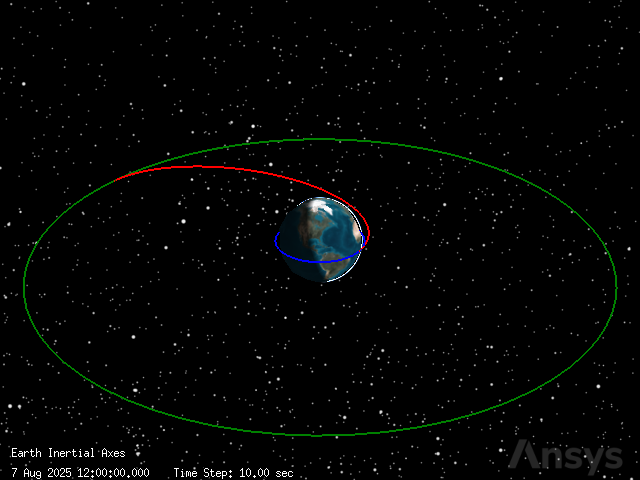

In [23]:
plotter.camera.position = [57000, 85000, 55000]
plotter.show()